In [2]:
#Import libraries 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import boto3
import sagemaker
import io
from sagemaker.session import Session
from sagemaker.s3 import S3Downloader, S3Uploader

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


# S3 Datalake

In [3]:
import warnings 
warnings.filterwarnings('ignore') 

In [4]:
#View test and bid files
train_data = pd.read_csv("train.csv")
train_data.head()

,bidder_id,payment_account,address,outcome
0,91a3c57b13234af24875c56fb7e2b2f4rb56a,a3d2de7675556553a5f08e4c88d2c228754av,a3d2de7675556553a5f08e4c88d2c228vt0u4,0.0
1,624f258b49e77713fc34034560f93fb3hu3jo,a3d2de7675556553a5f08e4c88d2c228v1sga,ae87054e5a97a8f840a3991d12611fdcrfbq3,0.0
2,1c5f4fc669099bfbfac515cd26997bd12ruaj,a3d2de7675556553a5f08e4c88d2c2280cybl,92520288b50f03907041887884ba49c0cl0pd,0.0
3,4bee9aba2abda51bf43d639013d6efe12iycd,51d80e233f7b6a7dfdee484a3c120f3b2ita8,4cb9717c8ad7e88a9a284989dd79b98dbevyi,0.0
4,4ab12bc61c82ddd9c2d65e60555808acqgos1,a3d2de7675556553a5f08e4c88d2c22857ddh,2a96c3ce94b3be921e0296097b88b56a7x1ji,0.0


In [5]:
bid_data = pd.read_csv("bids.csv")
bid_data.head()

,bid_id,bidder_id,auction,merchandise,device,time,country,ip,url
0,0,8dac2b259fd1c6d1120e519fb1ac14fbqvax8,ewmzr,jewelry,phone0,9759243157894736,us,69.166.231.58,vasstdc27m7nks3
1,1,668d393e858e8126275433046bbd35c6tywop,aeqok,furniture,phone1,9759243157894736,in,50.201.125.84,jmqlhflrzwuay9c
2,2,aa5f360084278b35d746fa6af3a7a1a5ra3xe,wa00e,home goods,phone2,9759243157894736,py,112.54.208.157,vasstdc27m7nks3
3,3,3939ac3ef7d472a59a9c5f893dd3e39fh9ofi,jefix,jewelry,phone4,9759243157894736,in,18.99.175.133,vasstdc27m7nks3
4,4,8393c48eaf4b8fa96886edc7cf27b372dsibi,jefix,jewelry,phone5,9759243157894736,in,145.138.5.37,vasstdc27m7nks3


In [6]:
test_data = pd.read_csv("test.csv")

In [7]:
print("Bids Dataset Shape: ", bid_data.shape)
print("Train Dataset Shape: ", train_data.shape)
print("Test Dataset Shape: ", test_data.shape)

Bids Dataset Shape:  (7656334, 9)
Train Dataset Shape:  (2013, 4)
Test Dataset Shape:  (4700, 3)


In [8]:
#Setup S3 bucket and upload files 
bucket = Session().default_bucket()
region = boto3.Session().region_name
s3_client = boto3.client("s3", region_name=region)
sess = sagemaker.Session()
role = sagemaker.get_execution_role()

S3Uploader.upload("test.csv", f"s3://{bucket}/facebook-recruiting-iv-human-or-bot")
S3Uploader.upload("train.csv", f"s3://{bucket}/facebook-recruiting-iv-human-or-bot")
S3Uploader.upload("bids.csv", f"s3://{bucket}/facebook-recruiting-iv-human-or-bot")

's3://sagemaker-us-east-1-385225481548/facebook-recruiting-iv-human-or-bot/bids.csv'

# Athena Table SetUp

In [9]:
!pip install pyathena

In [10]:
from pyathena import connect

In [11]:
#Create Athena database and S3 staging directory
database_name = "bot_bids"
s3_staging_dir = "s3://{0}/athena/staging".format(bucket)
conn = connect(region_name=region, s3_staging_dir=s3_staging_dir)
statement = "CREATE DATABASE IF NOT EXISTS {}".format(database_name)
pd.read_sql(statement, conn)

""


In [12]:
#Verify database created successfully
statement = "SHOW DATABASES"
df_show = pd.read_sql(statement, conn)
df_show.head(1)

,database_name
0,bot_bids


In [13]:
# SQL statement to execute
bid_table_name_csv = "bids"
s3_data_path = f"s3://{bucket}/facebook-recruiting-iv-human-or-bot/"
statement = """CREATE EXTERNAL TABLE IF NOT EXISTS {}.{}(
         bid_id int,
         bidder_id string,
         auction string,
         merchandise string,
         device string,
         time timestamp,
         country string,
         ip string,
         url string
) ROW FORMAT DELIMITED FIELDS TERMINATED BY ',' LOCATION '{}'
TBLPROPERTIES ('skip.header.line.count'='1')""".format(
    database_name, bid_table_name_csv, s3_data_path
)

print(statement)

CREATE EXTERNAL TABLE IF NOT EXISTS bot_bids.bids(
         bid_id int,
         bidder_id string,
         auction string,
         merchandise string,
         device string,
         time timestamp,
         country string,
         ip string,
         url string
) ROW FORMAT DELIMITED FIELDS TERMINATED BY ',' LOCATION 's3://sagemaker-us-east-1-385225481548/facebook-recruiting-iv-human-or-bot/'
TBLPROPERTIES ('skip.header.line.count'='1')


In [14]:
pd.read_sql(statement, conn)

""


In [15]:
#Verify the table is created 
statement = "SHOW TABLES in {}".format(database_name)
df_show = pd.read_sql(statement, conn)
df_show.head(5)

,tab_name
0,bids


# Exploratory Data Analysis

In [16]:
#Find missing values and calculate percentage that are missing
bid_data.isnull().sum()

bid_id            0
bidder_id         0
auction           0
merchandise       0
device            0
time              0
country        8859
ip                0
url               0
dtype: int64

In [17]:
missing_percent = bid_data['country'].isnull().mean()
print(f"Percentage of missing data in country column: {missing_percent*100: .2f}%")

Percentage of missing data in country column:  0.12%


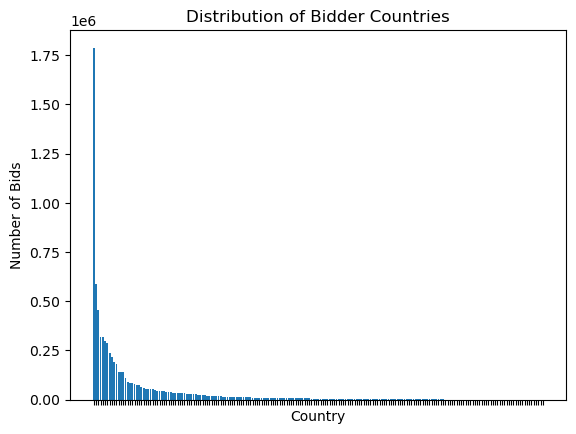

In [18]:
#Check country distribution
unique_countries = bid_data['country'].value_counts()
plt.bar(unique_countries.index, unique_countries.values)
plt.xticks(visible=False)   
plt.title("Distribution of Bidder Countries")
plt.xlabel("Country")
plt.ylabel("Number of Bids")
plt.show()

In [19]:
#Since one country has dramaticaly more bids than the others, fill the NA values with the mode
bid_data['country'] = bid_data['country'].fillna(bid_data['country'].mode()[0])

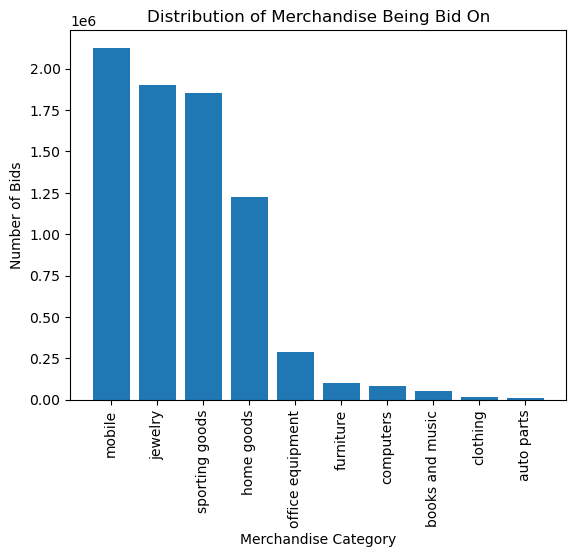

In [20]:
#Check merchandise distribution 
unique_products = bid_data['merchandise'].value_counts()
plt.bar(unique_products.index, unique_products.values)
plt.title("Distribution of Merchandise Being Bid On")
plt.xlabel("Merchandise Category")
plt.ylabel("Number of Bids")
plt.xticks(rotation=90)                    
plt.show()

In [21]:
#View distribution of bot vs human bids in training dataset
#Uneven distribution indicates oversampling will be needed
train_data['outcome'].value_counts()

outcome
0.0    1910
1.0     103
Name: count, dtype: int64

# Feature Store

In [22]:
#Setup Feature store
boto_session = boto3.Session(region_name=region)
sagemaker_client = boto_session.client(service_name="sagemaker", region_name=region)
featurestore_runtime = boto_session.client(
    service_name="sagemaker-featurestore-runtime", region_name=region
)

feature_store_session = Session(
    boto_session=boto_session,
    sagemaker_client=sagemaker_client,
    sagemaker_featurestore_runtime_client=featurestore_runtime,
)

default_s3_bucket_name = feature_store_session.default_bucket()
prefix = "sagemaker-featurestore"

print(default_s3_bucket_name)

sagemaker-us-east-1-385225481548


In [23]:
# bot_bids_bucket_name = f"sagemaker-bid-bids-{region}"
bot_bids_bucket_name = default_s3_bucket_name
bids_file_key = (
    "facebook-recruiting-iv-human-or-bot/bids.csv"
)
train_file_key = (
    "facebook-recruiting-iv-human-or-bot/train.csv"
)

bids_data_object = s3_client.get_object(
    Bucket=bot_bids_bucket_name, Key=bids_file_key
)
train_data_object = s3_client.get_object(
    Bucket=bot_bids_bucket_name, Key=train_file_key
)

# Feature Engineering 

In [24]:
#Identify unique feature counts 
bidder_unique = bid_data.groupby("bidder_id").nunique().reset_index()
bidder_unique.head()

,bidder_id,bid_id,auction,merchandise,device,time,country,ip,url
0,001068c415025a009fee375a12cff4fcnht8y,1,1,1,1,1,1,1,1
1,002d229ffb247009810828f648afc2ef593rb,2,1,1,2,2,1,1,1
2,0030a2dd87ad2733e0873062e4f83954mkj86,1,1,1,1,1,1,1,1
3,003180b29c6a5f8f1d84a6b7b6f7be57tjj1o,3,3,1,3,3,1,3,2
4,00486a11dff552c4bd7696265724ff81yeo9v,20,13,1,8,20,1,10,7


In [25]:
#Merge bid and train datasets and drop payment account and address as they provide no additional information
train_set = train_data.merge(bidder_unique, on='bidder_id', how='left').drop(columns = ['payment_account', 'address'], 
                                                                           errors = 'ignore')
train_set = train_set.rename(columns = {'bid_id': 'num_bids', 'auction': 'num_auct', 'merchandise': 'num_merch_type', 
                                        'device': 'num_device_type', 'time': 'num_time', 'country': 'num_ctry', 
                                        'ip': 'num_ip', 'url': 'num_url'})
train_set = train_set.fillna(0)
train_set.head()

,bidder_id,outcome,num_bids,num_auct,num_merch_type,num_device_type,num_time,num_ctry,num_ip,num_url
0,91a3c57b13234af24875c56fb7e2b2f4rb56a,0.0,24.0,18.0,1.0,14.0,24.0,6.0,20.0,1.0
1,624f258b49e77713fc34034560f93fb3hu3jo,0.0,3.0,1.0,1.0,2.0,3.0,1.0,3.0,2.0
2,1c5f4fc669099bfbfac515cd26997bd12ruaj,0.0,4.0,4.0,1.0,2.0,4.0,1.0,4.0,2.0
3,4bee9aba2abda51bf43d639013d6efe12iycd,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,4ab12bc61c82ddd9c2d65e60555808acqgos1,0.0,155.0,23.0,1.0,53.0,155.0,2.0,123.0,91.0


In [26]:
#Repeat for test data
test_set = test_data.merge(bidder_unique, on='bidder_id', how='left').drop(columns = ['payment_account', 'address'], 
                                                                           errors = 'ignore')
test_set = test_set.rename(columns = {'bid_id': 'num_bids', 'auction': 'num_auct', 'merchandise': 'num_merch_type', 
                                      'device': 'num_device_type', 'time': 'num_time', 'country': 'num_ctry', 
                                      'ip': 'num_ip', 'url': 'num_url'})
test_set = test_set.fillna(0)

In [27]:
print("Train Dataset Shape: ", train_set.shape)
print("Test Dataset Shape: ", test_set.shape)

Train Dataset Shape:  (2013, 10)
Test Dataset Shape:  (4700, 9)


# Feature Groups 

In [28]:
#Define feature groups
import time
from time import gmtime, strftime, sleep
from sagemaker.feature_store.feature_group import FeatureGroup

train_feature_group_name = "train-feature-group-" + strftime("%d-%H-%M-%S", gmtime())
test_feature_group_name = "test-feature-group-" + strftime("%d-%H-%M-%S", gmtime())

train_feature_group = FeatureGroup(
    name=train_feature_group_name, sagemaker_session=feature_store_session
)
test_feature_group = FeatureGroup(
    name=test_feature_group_name, sagemaker_session=feature_store_session
)

current_time_sec = int(round(time.time()))

def cast_object_to_string(data_frame):
    for label in data_frame.columns:
        if data_frame.dtypes[label] == "object":
            data_frame[label] = data_frame[label].astype("str").astype("string")


# cast object dtype to string. The SageMaker FeatureStore Python SDK will then 
#map the string dtype to String feature type.
cast_object_to_string(test_set)
cast_object_to_string(train_set)

# record identifier and event time feature names
record_identifier_feature_name = "bidder_id"
event_time_feature_name = "EventTime"

# append EventTime feature
train_set[event_time_feature_name] = pd.Series(
    [current_time_sec] * len(train_set), dtype="float64"
)
test_set[event_time_feature_name] = pd.Series(
    [current_time_sec] * len(test_set), dtype="float64"
)

# load feature definitions to the feature group
train_feature_group.load_feature_definitions(data_frame=train_set)
test_feature_group.load_feature_definitions(data_frame=test_set)

[FeatureDefinition(feature_name='bidder_id', feature_type=<FeatureTypeEnum.STRING: 'String'>, collection_type=None),
 FeatureDefinition(feature_name='num_bids', feature_type=<FeatureTypeEnum.FRACTIONAL: 'Fractional'>, collection_type=None),
 FeatureDefinition(feature_name='num_auct', feature_type=<FeatureTypeEnum.FRACTIONAL: 'Fractional'>, collection_type=None),
 FeatureDefinition(feature_name='num_merch_type', feature_type=<FeatureTypeEnum.FRACTIONAL: 'Fractional'>, collection_type=None),
 FeatureDefinition(feature_name='num_device_type', feature_type=<FeatureTypeEnum.FRACTIONAL: 'Fractional'>, collection_type=None),
 FeatureDefinition(feature_name='num_time', feature_type=<FeatureTypeEnum.FRACTIONAL: 'Fractional'>, collection_type=None),
 FeatureDefinition(feature_name='num_ctry', feature_type=<FeatureTypeEnum.FRACTIONAL: 'Fractional'>, collection_type=None),
 FeatureDefinition(feature_name='num_ip', feature_type=<FeatureTypeEnum.FRACTIONAL: 'Fractional'>, collection_type=None),
 Fea

In [29]:
def wait_for_feature_group_creation_complete(feature_group):
    status = feature_group.describe().get("FeatureGroupStatus")
    while status == "Creating":
        print("Waiting for Feature Group Creation")
        time.sleep(10)
        status = feature_group.describe().get("FeatureGroupStatus")
    if status != "Created":
        raise RuntimeError(f"Failed to create feature group {feature_group.name}")
    print(f"FeatureGroup {feature_group.name} successfully created.")


train_feature_group.create(
    s3_uri=f"s3://{default_s3_bucket_name}/{prefix}",
    record_identifier_name=record_identifier_feature_name,
    event_time_feature_name=event_time_feature_name,
    role_arn=role,
    enable_online_store=True,
)

test_feature_group.create(
    s3_uri=f"s3://{default_s3_bucket_name}/{prefix}",
    record_identifier_name=record_identifier_feature_name,
    event_time_feature_name=event_time_feature_name,
    role_arn=role,
    enable_online_store=True,
)

wait_for_feature_group_creation_complete(feature_group=train_feature_group)
wait_for_feature_group_creation_complete(feature_group=test_feature_group)

Waiting for Feature Group Creation
Waiting for Feature Group Creation
FeatureGroup train-feature-group-12-22-17-54 successfully created.
Waiting for Feature Group Creation
FeatureGroup test-feature-group-12-22-17-54 successfully created.


In [30]:
train_feature_group.describe()

{'FeatureGroupArn': 'arn:aws:sagemaker:us-east-1:385225481548:feature-group/train-feature-group-12-22-17-54',
 'FeatureGroupName': 'train-feature-group-12-22-17-54',
 'RecordIdentifierFeatureName': 'bidder_id',
 'EventTimeFeatureName': 'EventTime',
 'FeatureDefinitions': [{'FeatureName': 'bidder_id', 'FeatureType': 'String'},
  {'FeatureName': 'outcome', 'FeatureType': 'Fractional'},
  {'FeatureName': 'num_bids', 'FeatureType': 'Fractional'},
  {'FeatureName': 'num_auct', 'FeatureType': 'Fractional'},
  {'FeatureName': 'num_merch_type', 'FeatureType': 'Fractional'},
  {'FeatureName': 'num_device_type', 'FeatureType': 'Fractional'},
  {'FeatureName': 'num_time', 'FeatureType': 'Fractional'},
  {'FeatureName': 'num_ctry', 'FeatureType': 'Fractional'},
  {'FeatureName': 'num_ip', 'FeatureType': 'Fractional'},
  {'FeatureName': 'num_url', 'FeatureType': 'Fractional'},
  {'FeatureName': 'EventTime', 'FeatureType': 'Fractional'}],
 'CreationTime': datetime.datetime(2024, 6, 12, 22, 17, 55, 2

In [31]:
#Put records into the feature group
train_feature_group.ingest(data_frame=train_set, max_workers=3, wait=True)

IngestionManagerPandas(feature_group_name='train-feature-group-12-22-17-54', feature_definitions={'bidder_id': {'FeatureName': 'bidder_id', 'FeatureType': 'String'}, 'outcome': {'FeatureName': 'outcome', 'FeatureType': 'Fractional'}, 'num_bids': {'FeatureName': 'num_bids', 'FeatureType': 'Fractional'}, 'num_auct': {'FeatureName': 'num_auct', 'FeatureType': 'Fractional'}, 'num_merch_type': {'FeatureName': 'num_merch_type', 'FeatureType': 'Fractional'}, 'num_device_type': {'FeatureName': 'num_device_type', 'FeatureType': 'Fractional'}, 'num_time': {'FeatureName': 'num_time', 'FeatureType': 'Fractional'}, 'num_ctry': {'FeatureName': 'num_ctry', 'FeatureType': 'Fractional'}, 'num_ip': {'FeatureName': 'num_ip', 'FeatureType': 'Fractional'}, 'num_url': {'FeatureName': 'num_url', 'FeatureType': 'Fractional'}, 'EventTime': {'FeatureName': 'EventTime', 'FeatureType': 'Fractional'}}, sagemaker_fs_runtime_client_config=<botocore.config.Config object at 0x7fef90a5ab90>, sagemaker_session=<sagemake

In [32]:
test_feature_group.ingest(data_frame=test_set, max_workers=3, wait=True)

IngestionManagerPandas(feature_group_name='test-feature-group-12-22-17-54', feature_definitions={'bidder_id': {'FeatureName': 'bidder_id', 'FeatureType': 'String'}, 'num_bids': {'FeatureName': 'num_bids', 'FeatureType': 'Fractional'}, 'num_auct': {'FeatureName': 'num_auct', 'FeatureType': 'Fractional'}, 'num_merch_type': {'FeatureName': 'num_merch_type', 'FeatureType': 'Fractional'}, 'num_device_type': {'FeatureName': 'num_device_type', 'FeatureType': 'Fractional'}, 'num_time': {'FeatureName': 'num_time', 'FeatureType': 'Fractional'}, 'num_ctry': {'FeatureName': 'num_ctry', 'FeatureType': 'Fractional'}, 'num_ip': {'FeatureName': 'num_ip', 'FeatureType': 'Fractional'}, 'num_url': {'FeatureName': 'num_url', 'FeatureType': 'Fractional'}, 'EventTime': {'FeatureName': 'EventTime', 'FeatureType': 'Fractional'}}, sagemaker_fs_runtime_client_config=<botocore.config.Config object at 0x7fef90a5ab90>, sagemaker_session=<sagemaker.session.Session object at 0x7fefa88f9de0>, max_workers=3, max_proce

In [33]:
#Ensure data is ingested by retrieving a record
featurestore_runtime.get_record(
    FeatureGroupName=train_feature_group_name,
    RecordIdentifierValueAsString="91a3c57b13234af24875c56fb7e2b2f4rb56a",
)

{'ResponseMetadata': {'RequestId': '4df946b3-6b46-4530-a5b1-a65dd3036b7e',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '4df946b3-6b46-4530-a5b1-a65dd3036b7e',
   'content-type': 'application/json',
   'content-length': '902',
   'date': 'Wed, 12 Jun 2024 22:19:07 GMT'},
  'RetryAttempts': 0},
 'Record': [{'FeatureName': 'bidder_id',
   'ValueAsString': '91a3c57b13234af24875c56fb7e2b2f4rb56a'},
  {'FeatureName': 'outcome', 'ValueAsString': '0.0'},
  {'FeatureName': 'num_bids', 'ValueAsString': '24.0'},
  {'FeatureName': 'num_auct', 'ValueAsString': '18.0'},
  {'FeatureName': 'num_merch_type', 'ValueAsString': '1.0'},
  {'FeatureName': 'num_device_type', 'ValueAsString': '14.0'},
  {'FeatureName': 'num_time', 'ValueAsString': '24.0'},
  {'FeatureName': 'num_ctry', 'ValueAsString': '6.0'},
  {'FeatureName': 'num_ip', 'ValueAsString': '20.0'},
  {'FeatureName': 'num_url', 'ValueAsString': '1.0'},
  {'FeatureName': 'EventTime', 'ValueAsString': '1718230675.0'}]}

In [ ]:
#Wait for data to be available in the offline store
account_id = boto3.client("sts").get_caller_identity()["Account"]
print(account_id)

train_feature_group_resolved_output_s3_uri = (
    train_feature_group.describe()
    .get("OfflineStoreConfig")
    .get("S3StorageConfig")
    .get("ResolvedOutputS3Uri")
)
test_feature_group_resolved_output_s3_uri = (
    test_feature_group.describe()
    .get("OfflineStoreConfig")
    .get("S3StorageConfig")
    .get("ResolvedOutputS3Uri")
)

train_feature_group_s3_prefix = train_feature_group_resolved_output_s3_uri.replace(
    f"s3://{default_s3_bucket_name}/", ""
)
test_feature_group_s3_prefix = test_feature_group_resolved_output_s3_uri.replace(
    f"s3://{default_s3_bucket_name}/", ""
)

offline_store_contents = None
while offline_store_contents is None:
    objects_in_bucket = s3_client.list_objects(
        Bucket=default_s3_bucket_name, Prefix=train_feature_group_s3_prefix
    )
    if "Contents" in objects_in_bucket and len(objects_in_bucket["Contents"]) > 1:
        offline_store_contents = objects_in_bucket["Contents"]
    else:
        print("Waiting for data in offline store...\n")
        sleep(60)

print("Data available.")

385225481548
Waiting for data in offline store...

Waiting for data in offline store...

Waiting for data in offline store...

Waiting for data in offline store...

Waiting for data in offline store...

Waiting for data in offline store...



# Split Data

In [ ]:
#Due to train set only containing labels, it is split into train:test:validation 80:10:10
#Test set with no labels is reserved for production data
rand_split = np.random.rand(len(train_set))
train_list = rand_split < 0.8
val_list = (rand_split >= 0.8) & (rand_split < 0.9)
test_list = rand_split >= 0.9

#the bidder_id is not a training feature
data_train = train_set[train_list].drop(["bidder_id"], axis=1)
data_val = train_set[val_list].drop(["bidder_id"], axis=1)
data_test = train_set[test_list].drop(["outcome"], axis=1)
data_test_noID = data_test.drop(["bidder_id"], axis=1)

data_prod = test_set

In [ ]:
#Upload files into S3
train_file = "train_data.csv"
data_train.to_csv(train_file, index=False, header=False)
sess.upload_data(train_file, key_prefix="{}/train".format(prefix))

validation_file = "validation_data.csv"
data_val.to_csv(validation_file, index=False, header=False)
sess.upload_data(validation_file, key_prefix="{}/validation".format(prefix))

test_file = "test_data.csv"
data_test.to_csv(test_file, index=False, header=False)
sess.upload_data(test_file, key_prefix="{}/batch".format(prefix))

test_file_noID = "test_data_noID.csv"
data_test_noID.to_csv(test_file_noID, index=False, header=False)
sess.upload_data(test_file_noID, key_prefix="{}/batch".format(prefix))

prod_file = "prod_data.csv"
data_prod.to_csv(prod_file, index=False, header=False)
sess.upload_data(prod_file, key_prefix="{}/prod".format(prefix))

# Cleanup Resources

In [ ]:
train_feature_group.delete()
test_feature_group.delete()